## In this notebook, we'll work on a classification problem (predicting whether something is one thing or another).

In [ ]:
import torch

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
#   For consistency, the dataset should have 1000 samples and a random_state=42.
#   Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

# Import dependencies
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Make and plot data
X_moon, y_moon = make_moons(n_samples=1000,
                            noise=0.07,
                            random_state=42)

X_moon[:10], y_moon[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

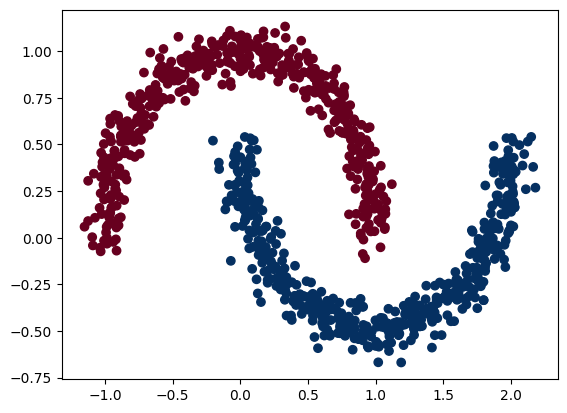

In [ ]:
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.RdBu);

In [ ]:
# Turn data into a DataFrame
import pandas as pd
data_df = pd.DataFrame({"X0": X_moon[:, 0],
                        "X1": X_moon[:, 1],
                        "y": y_moon})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


In [ ]:
# Convert to tensors and split into train (80%) and test (20%) sets
# X_moon = torch.from_numpy(X_moon).type(torch.float).to(device)  # both ways work
# y_moon = torch.from_numpy(y_moon).type(torch.float).to(device)
X_moon = torch.tensor(X_moon, dtype=torch.float).to(device)
y_moon = torch.tensor(y_moon, dtype=torch.float).to(device)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_moon,
    y_moon,
    test_size=0.2,
    random_state=42
)

# X_train[:5], y_train[:5]
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
#2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
#   Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

# Build model with non-linear activation function
from torch import nn

class MoonModelV1(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()

    self.layer1 = nn.Linear(in_features=in_features, out_features=hidden_units)  # (in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units) # (in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=hidden_units, out_features=out_features) # (in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_1 = MoonModelV1(in_features=2,
                      hidden_units=10,
                      out_features=1).to(device)
model_1

MoonModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.1807, -0.4035],
                      [-0.2421, -0.5283],
                      [ 0.2522,  0.5473],
                      [-0.6657,  0.1642],
                      [ 0.3653,  0.1282],
                      [-0.2518,  0.3691],
                      [ 0.3716,  0.2644],
                      [-0.1243, -0.1872],
                      [ 0.0756, -0.1249],
                      [-0.2107,  0.4520]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.6077, -0.0700, -0.1583,  0.0103, -0.0422,  0.1700,  0.1982, -0.6422,
                      -0.2609,  0.5955], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.1232, -0.0157, -0.1907, -0.1935, -0.2833, -0.1031,  0.1068,  0.2016,
                        0.1460, -0.2795],
                      [-0.1902, -0.0499,  0.3059,  0.0457, -0.0819,  0.1308, -0.1204, -0.2047,
                        0.2308, -0.1438],
                      [-0.0634, -0.3146, 

In [ ]:
#3. Setup a binary classification compatible loss function and optimizer to use when training the model.

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()  # sigmoid layer built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),  # parameters of model to optimize
                            lr=0.1)                       # learning rate

In [ ]:
# Create an accuracy function
"""
def accuracy_fn(y_true, y_pred):
  # torch.eq() calculates where two tensors are equal
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc
"""
!pip -q install torchmetrics  # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [ ]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_1(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_1(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_1(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.2283, 0.1189, 0.1483, 0.1443, 0.1042, 0.1397, 0.1095, 0.1004, 0.1590,
        0.1070], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5568, 0.5297, 0.5370, 0.5360, 0.5260, 0.5349, 0.5273, 0.5251, 0.5397,
        0.5267], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [ ]:
#4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
#   To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
#   Train the model for long enough for it to reach over 96% accuracy.
#   The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss calculates loss using logits
                                     # loss = compare model raw outputs to desired model outputs
#  acc = accuracy_fn(y_true=y_train,
#                    y_pred=y_pred)
  acc = acc_fn(y_pred, y_train.int())  # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Optimizer zero grad
  optimizer.zero_grad()              # I'd forgotten the ending () before and it wasn't matching his results!

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calc loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
#    test_acc = accuracy_fn(y_true=y_test,
#                           y_pred=test_pred)
    test_acc = acc_fn(test_pred, y_test.int())

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70 Acc: 0.50 | Test loss: 0.70 Test acc: 0.50
Epoch: 100 | Loss: 0.38 Acc: 0.83 | Test loss: 0.39 Test acc: 0.81
Epoch: 200 | Loss: 0.24 Acc: 0.88 | Test loss: 0.24 Test acc: 0.89
Epoch: 300 | Loss: 0.21 Acc: 0.91 | Test loss: 0.21 Test acc: 0.90
Epoch: 400 | Loss: 0.19 Acc: 0.92 | Test loss: 0.19 Test acc: 0.90
Epoch: 500 | Loss: 0.16 Acc: 0.93 | Test loss: 0.16 Test acc: 0.91
Epoch: 600 | Loss: 0.13 Acc: 0.94 | Test loss: 0.13 Test acc: 0.95
Epoch: 700 | Loss: 0.10 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 800 | Loss: 0.07 Acc: 0.98 | Test loss: 0.06 Test acc: 0.99
Epoch: 900 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00


In [ ]:
#5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

# Plot the model predictions
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

  # Put everything to CPU (works better with NumPy + Matplotlib)
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                       np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # multi-class
  else:
    y_pred = torch.round(torch.sigmoid(y_logits)) # binary

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

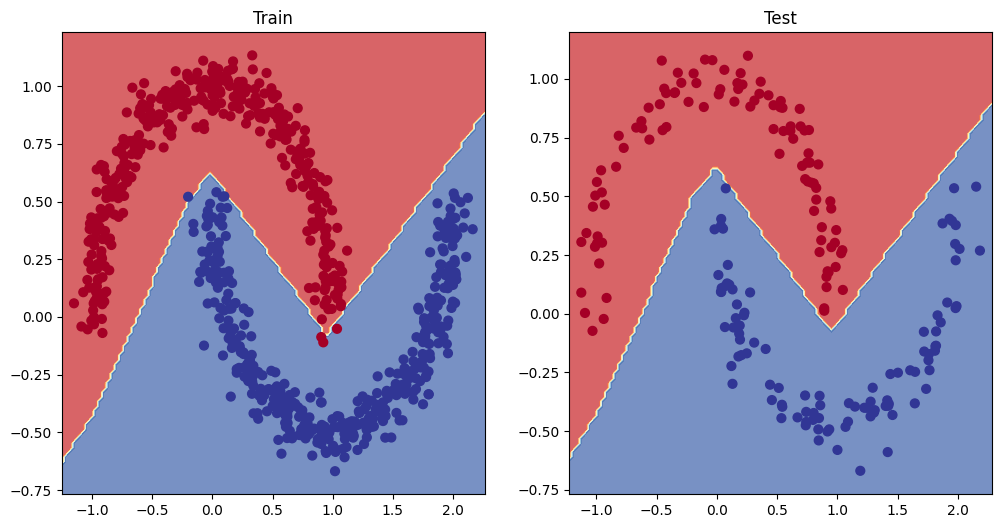

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

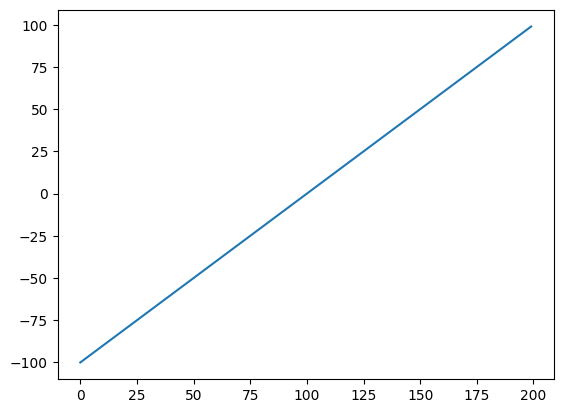

In [ ]:
#6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A) # works with ; or without

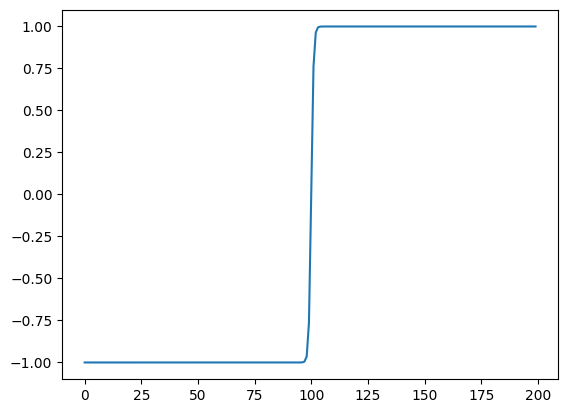

In [ ]:
plt.plot(torch.tanh(tensor_A))

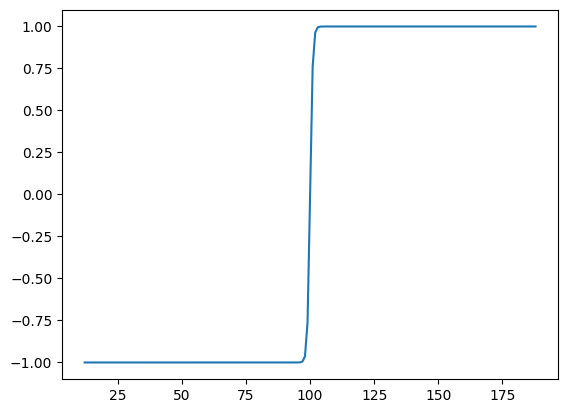

In [ ]:
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

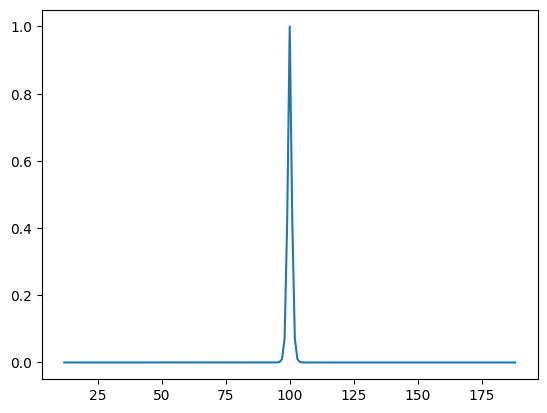

In [ ]:
def tanh_prime(x):
  return 1 - tanh(x)**2

plt.plot(tanh_prime(tensor_A))

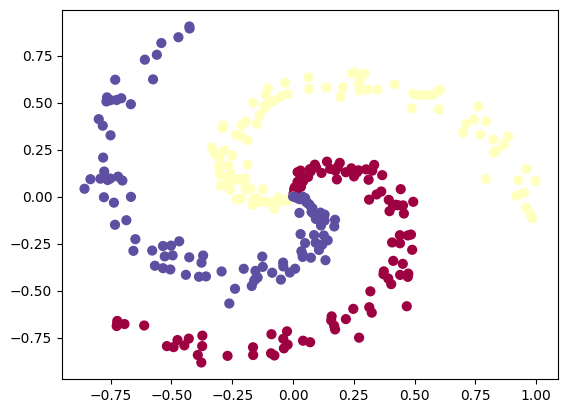

In [ ]:
#7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

# Code for creating a spiral dataset from CS231n
# import numpy as np
np.random.seed(42)

N = 100  # number of points per class
D = 2    # dimensionality
K = 3    # number of classes
X = np.zeros((N*K, D))            # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8')  # class labels

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0, 1, N)      # radius
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
# Convert data to tensors
# X = torch.tensor(X, dtype=torch.float)
# y = torch.tensor(y, dtype=torch.long)
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Split into train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [ ]:
# Build model with non-linear activation function
# from torch import nn

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_S = SpiralModel().to(device)
model_S

SpiralModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(model_S.parameters(),
                             lr=0.02)

In [ ]:
# Create an accuracy function
# !pip -q install torchmetrics  # colab doesn't come with torchmetrics
# from torchmetrics import Accuracy

acc_fn2 = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn2

MulticlassAccuracy()

In [ ]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_S(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_S(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_S(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792],
        [-0.2195, -0.0565,  0.2457],
        [-0.2212, -0.0581,  0.2440],
        [-0.2251, -0.0631,  0.2354],
        [-0.2116, -0.0548,  0.2336],
        [-0.2170, -0.0552,  0.2842]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299],
        [0.2653, 0.3123, 0.4224],
        [0.2653, 0.3123, 0.4224],
        [0.2659, 0.3127, 0.4214],
        [0.2681, 0.3136, 0.4184],
        [0.2614, 0.3072, 0.4314]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [ ]:
# Build a training loop for the model
epochs = 1000

# Loop over the data
for epoch in range(epochs):
  ### Training
  model_S.train()

  # 1. Forward pass
  y_logits = model_S(X_train)  # why don't we .squeeze() ?
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calc loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn2(y_pred, y_train)\

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_S.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_S(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # Calc loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn2(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.45 Acc: 0.78 | Test loss: 0.53 Test acc: 0.68
Epoch: 200 | Loss: 0.12 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


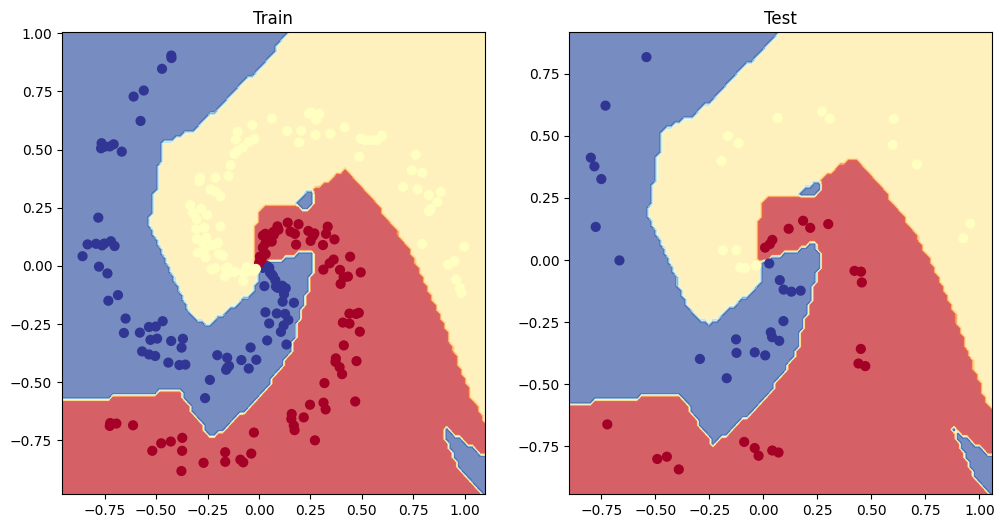

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_S, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_S, X_test, y_test)

In [ ]:
from google.colab import runtime
runtime.unassign()